In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np

### Test with toy model

In [2]:
topology = paths.engines.toy.Topology(n_spatial=3, 
                                      n_atoms=2, 
                                      masses=np.array([2.0, 8.0]), 
                                      pes=None)
initial_snapshot = paths.engines.toy.Snapshot(
    coordinates=np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    velocities=np.array([[0.0, 0.0, 0.0], [0.0, 0.0, 0.0]]),
    engine=paths.engines.toy.Engine({}, topology)
)

We'll define the modifier at two different temperatures, and we'll run each for 10000 snapshots. Note also that our two atoms have different masses.

In [3]:
modifier_1 = paths.RandomVelocities(beta=1.0)
modifier_5 = paths.RandomVelocities(beta=1.0/5.0)

In [4]:
snapshots_1 = [modifier_1(initial_snapshot) for i in range(10000)]
snapshots_5 = [modifier_5(initial_snapshot) for i in range(10000)]

Within each atom, all 3 DOFs will be part of the same distribution. We create a few lists with names of the form `v_${BETA}_${ATOM_NUMBER}`. These are the results we'll histogram and test.

In [5]:
v_1_0 = sum([s.velocities[0].tolist() for s in snapshots_1], [])
v_1_1 = sum([s.velocities[1].tolist() for s in snapshots_1], [])
v_5_0 = sum([s.velocities[0].tolist() for s in snapshots_5], [])
v_5_1 = sum([s.velocities[1].tolist() for s in snapshots_5], [])

We know what the distribution should look like, so we write it down explicitly:

In [6]:
def expected(beta, mass, v):
    alpha = 0.5*beta*mass
    return np.sqrt(alpha/np.pi)*np.exp(-alpha*v**2)

Now we take each total distribution, and compare it to the expected distribution. This is where we have to use our eyes to check the correctness.

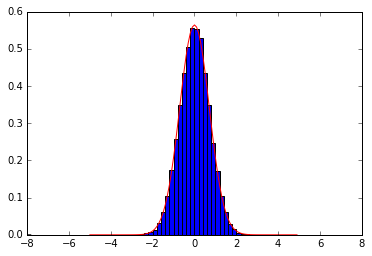

In [7]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_1_0, bins=bins, normed=True)
plt.plot(v, expected(1.0, 2.0, v), 'r');

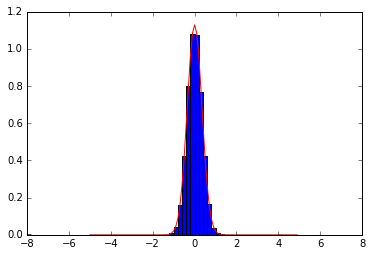

In [8]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_1_1, bins=bins, normed=True)
plt.plot(v, expected(1.0, 8.0, v), 'r');

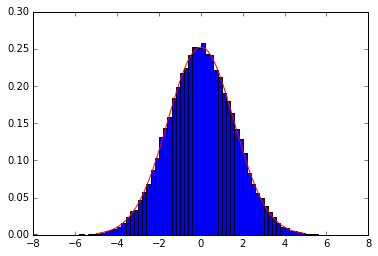

In [9]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_5_0, bins=bins, normed=True)
plt.plot(v, expected(0.2, 2.0, v), 'r');

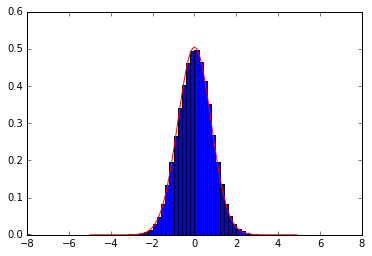

In [10]:
v = np.arange(-5.0, 5.0, 0.1)
bins = np.arange(-8.0, 8.0, 0.2)
plt.hist(v_5_1, bins=bins, normed=True)
plt.plot(v, expected(0.2, 8.0, v), 'r');

If the red lines match the blue histograms, we're good. Otherwise, something has gone terribly wrong.

### Test with OpenMM

In [11]:
import openmmtools as omt
import openpathsampling.engines.openmm as omm_engine
import simtk.unit as u
test_system = omt.testsystems.AlanineDipeptideVacuum()
template = omm_engine.snapshot_from_testsystem(test_system)

In [12]:
# just to show that the initial velocities are all 0
template.velocities

Quantity(value=array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]]), unit=nanometer/picosecond)

In [13]:
temperature = 300.0 * u.kelvin
beta = 1.0 / (temperature * u.BOLTZMANN_CONSTANT_kB)

In [14]:
full_randomizer = paths.RandomVelocities(beta)
fully_randomized_snapshot = full_randomizer(template)
fully_randomized_snapshot.velocities

Quantity(value=array([[ 3.76941191,  1.78609853, -0.42122272],
       [-0.17535131,  0.35369027, -0.24590955],
       [ 2.16046342, -2.31063603, -0.52710453],
       [ 0.51451663, -0.05331294, -1.00461654],
       [ 0.34847886, -1.01320999, -0.04526457],
       [-0.10205742, -0.2339511 , -0.50190899],
       [-0.28664876, -0.2868359 ,  0.1669952 ],
       [ 0.62536248, -2.19736216, -0.73649514],
       [ 0.01000426, -0.47292456,  0.93872149],
       [ 4.72110997,  0.31382452,  0.15547128],
       [-0.86802828, -0.27896975,  0.09217331],
       [ 2.28214701, -0.55149094,  1.7578447 ],
       [ 0.82507471,  3.14090997, -0.6584575 ],
       [ 1.44800185, -0.06430261, -0.06834671],
       [ 0.58563485,  0.19959048, -0.44880419],
       [ 0.11069778,  0.28236978,  0.11319233],
       [-0.12183198,  0.11243573, -0.00715614],
       [ 0.47449335,  1.07805655, -2.32925   ],
       [ 0.71404471, -1.18140548,  0.04352177],
       [ 2.81046465, -0.81413192,  1.21743085],
       [ 1.83667893, -0.4

That version randomized all velcoties; we can also create a `SnapshotModifier` that only modifies certain velocities. For example, we might be interested in modifying the velocities of a solvent while ignoring the solute.

Next we create a little example that only modifies the velocities of the carbon atoms in alanine dipeptide.

In [15]:
carbon_atoms = template.topology.mdtraj.select("element C")
carbon_randomizer = paths.RandomVelocities(beta, subset_mask=carbon_atoms)
carbon_randomized_snapshot = carbon_randomizer(template)
carbon_randomized_snapshot.velocities

Quantity(value=array([[ 0.        ,  0.        ,  0.        ],
       [-0.10039424, -0.37952337,  0.80936727],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.76864287, -0.44650717,  0.1323624 ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.14217394,  0.05680741, -0.54267357],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.38322834, -1.37001485, -1.10588162],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.72567783, -0.25714905,  0.35599565],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-0.04012117,  0.26081787,  0.74226423],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0. 

Note that only the 6 carbon atoms, selected by the `subset_mask`, have changed velocities from the template's value of `0.0`.

Finally, we'll check that the OpenMM version is giving the right statistics:

In [17]:
carbon_velocities = [carbon_randomizer(template).velocities[carbon_atoms] for i in range(1000)]

In [18]:
all_dof_values = sum(np.concatenate(carbon_velocities).tolist(), [])
print len(all_dof_values)

In [20]:
dalton_mass = 12.0
# manually doing conversions here
carbon_mass = dalton_mass / (6.02*10**23) * 10**-3 # kg
boltzmann = 1.38 * 10**-23 # J/K
m_s__to__nm_ps = 10**-3

temperature = 300.0 # K

kB_T = boltzmann * temperature * m_s__to__nm_ps**2

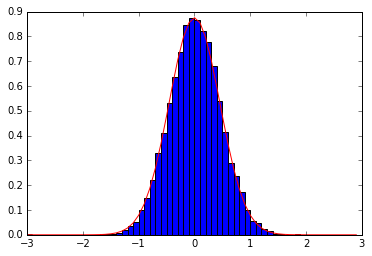

In [21]:
v = np.arange(-3.0, 3.0, 0.1)
bins = np.arange(-3.0, 3.0, 0.1)
plt.hist(all_dof_values, bins=bins, normed=True);
plt.plot(v, expected(1.0/kB_T, carbon_mass, v), 'r')